## Event reproducibility in RSC
### data from Franco and Goard 2021
See the paper:    
*"A distributed circuit for associating environmental context with motor choice in retrosplenial cortex"*    
Luis M. Franco Michael J. Goard    
Science Advances 7, eabf9815 (2021). doi:10.1126/sciadv.abf9815

In [1]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


### Data preprocessing

The original file `twoPhotonData.mat` containing the DF/F traces is available on [Zenodo](https://zenodo.org/record/4734407/files/twoPhotonData.mat).

Here, to speed up the processing and reduce the dependencies, we use the Ca spiketrains extracted using the `deconvolve` function available in the library [OASIS](https://github.com/j-friedrich/OASIS/pull/19) (with all default parameters, and `penalty` of 1).

In [2]:
if os.path.exists('goard/spiketrains_twoPhotonData_unselected.npy'):
    all_spiketrains = np.load('goard/spiketrains_twoPhotonData_unselected.npy', allow_pickle=True)
    time = np.load('goard/time_twoPhotonData_unselected.npy', allow_pickle=True) # all time samples
    print("... loaded",len(all_spiketrains), "spiketrains for", len(time), "intervals")

exp_path = os.getcwd() + "/goard/"

frame_duration = 0.1 # sec, 10 frames per second, see Methods in Franco and Goard 2021

... loaded 7770 spiketrains for 20160 intervals


We separate the 29 sessions using the `cellsPerSession` field of the matlab file (here listed for simplicity).

In [3]:
cellsPerSession = [
    279, 136, 317, 296, 292, 281, 258, 279, 279, 271, 
    177, 257, 296, 253, 329, 230, 292, 181, 201, 292, 
    241, 382, 239, 249, 315, 262, 237, 321, 328
]
indices_cellsPerSession = np.cumsum(cellsPerSession)
print(indices_cellsPerSession)

sessions = np.split(all_spiketrains, indices_cellsPerSession)[:-1] # omit last empty split


[ 279  415  732 1028 1320 1601 1859 2138 2417 2688 2865 3122 3418 3671
 4000 4230 4522 4703 4904 5196 5437 5819 6058 6307 6622 6884 7121 7442
 7770]


## Dynamical analysis

Analysis for each session.

On average, the longest responses were for the 4th trial. We take it.



1/29
... loaded 279 spiketrains
... producing spike rasterplot per session
    population firing: 34.66±37.07 sp/frame
    cells firing rate: 0.12±0.33 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 43.6550781796016
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 60
    number of events per sec: 0.037025609379821044
    events duration: 1.000±0.518
    events size: 200.500±45.230
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 28
    # clusters (after removing those below reproducibility threshold): 19
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecifical

/tmp/ipykernel_1813/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1813/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality


4/29
... loaded 296 spiketrains
... producing spike rasterplot per session
    population firing: 36.56±29.60 sp/frame
    cells firing rate: 0.12±0.33 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 47.0250647282011
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 142
    number of events per sec: 0.07971706057373827
    events duration: 1.100±0.678
    events size: 191.500±46.353
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 47
    # clusters (after removing those below reproducibility threshold): 46
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster co

/tmp/ipykernel_1813/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1813/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality


17/29
... loaded 292 spiketrains
... producing spike rasterplot per session
    population firing: 36.68±41.23 sp/frame
    cells firing rate: 0.13±0.33 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 45.11697096311363
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 133
    number of events per sec: 0.07542675664946406
    events duration: 1.000±0.386
    events size: 220.000±56.944
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 19
    # clusters (after removing those below reproducibility threshold): 19
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster 

/tmp/ipykernel_1813/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality


21/29
... loaded 241 spiketrains
... producing spike rasterplot per session
    population firing: 24.06±23.46 sp/frame
    cells firing rate: 0.10±0.30 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 35.12802197536886
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 134
    number of events per sec: 0.07280234706074105
    events duration: 1.100±0.503
    events size: 181.000±37.796
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 36
    # clusters (after removing those below reproducibility threshold): 35
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster 

/tmp/ipykernel_1813/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality


22/29
... loaded 382 spiketrains
... producing spike rasterplot per session
    population firing: 45.08±31.69 sp/frame
    cells firing rate: 0.12±0.32 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 64.028413155334
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 113
    number of events per sec: 0.06433247936236834
    events duration: 0.900±1.362
    events size: 210.000±55.943
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 17
    # clusters (after removing those below reproducibility threshold): 17
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster co

/tmp/ipykernel_1813/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)


/tmp/ipykernel_1813/1776641453.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  hmmap.set_yscale('log')


... Flow Analysis
... PageRank centrality


23/29
... loaded 239 spiketrains
... producing spike rasterplot per session
    population firing: 29.60±19.83 sp/frame
    cells firing rate: 0.12±0.33 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 42.117268703180564
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 78
    number of events per sec: 0.04655604631729736
    events duration: 1.000±0.477
    events size: 140.500±27.536
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 14
    # clusters (after removing those below reproducibility threshold): 13
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster 

/tmp/ipykernel_1813/3803255186.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


    Local Clustering Coefficient (cores too)
... Flow Analysis
... PageRank centrality


28/29
... loaded 321 spiketrains
... producing spike rasterplot per session
    population firing: 37.16±28.01 sp/frame
    cells firing rate: 0.12±0.32 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 54.13516083143847
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 136
    number of events per sec: 0.074749917555238
    events duration: 1.100±0.610
    events size: 199.500±51.928
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.0
    cluster size threshold: 2
    Total number of clusters: 36
    # clusters (after removing those below reproducibility threshold): 34
    event color assignment
    unique color assignments
    cl

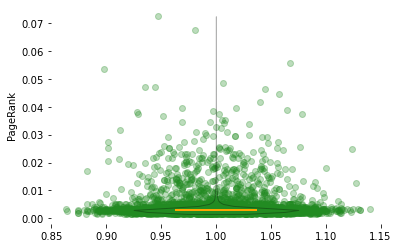

In [22]:
global_events = [[] for i in range(29)] # by session
global_events_vector = [[] for i in range(29)] # by session
global_events_sec = []
global_events_duration = []
global_cluster_number = []
global_cluster_selfsimilarity = [[] for i in range(29)]

core_reproducibility_perc = 99.9 # threshold for detecting cores

# there are session with NaNs
sessions_evt_toBremoved = [[] for i in range(29)] # by session
sessions_evt_toBremoved[0] = [22] 
sessions_evt_toBremoved[2] = [30]
sessions_evt_toBremoved[10] = [60,61]
sessions_evt_toBremoved[17] = [63,64,65,71,86,87,88]

all_degrees = []
all_core_degrees = []
all_local_clustering_coefficients = []
all_core_local_clustering_coefficients = []
all_pagerank_cores = []
all_pagerank_others = []

for scan_id,scan_spiketrains in enumerate(sessions):
    print("\n\n%d/%d" % (scan_id+1,len(sessions)))
    print("... loaded %s spiketrains"%(len(scan_spiketrains)))
    
    # we only take trial 4, starting at 1500 sec
    scan_spiketrains = [ np.nan_to_num(st[np.argwhere(np.array(st)>1500)[0][0]:], nan=0., posinf=0., neginf=0.).tolist() for st in scan_spiketrains]
    # scan_spiketrains = [ np.nan_to_num(st[np.argwhere(((np.array(st)>1500) and (np.array(st)<1600)))[0][0]:], nan=0., posinf=0., neginf=0.).tolist() for st in scan_spiketrains]

    start_time = 1500
    exp_tstart = start_time
    stop_time = max([max(st) if len(st) else 0 for st in scan_spiketrains])
    
    print("... producing spike rasterplot per session")
    fig = plt.figure()
    for row,train in enumerate(scan_spiketrains):
        plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
    plt.ylabel("cell IDs")
    plt.xlabel("time (s)")
    fig.savefig(exp_path+'/results/rasterplot_twoPhotonData_scan%s.png'%scan_id, transparent=True, dpi=800)
    plt.close()
    # fig.clear()
    # fig.clf()
    
    ophys_cell_ids = list(range(len(scan_spiketrains)))
    ophys_cell_indexes = ophys_cell_ids # alias
    extra_toBremoved = sessions_evt_toBremoved[scan_id]
    
    # --------------------------------------------------------------------------
    %run "dynamical_analysis.ipynb"

    global_events[scan_id].extend(events)
    global_events_vector[scan_id].extend(events_vectors)
    global_events_sec.append(events_sec)
    global_events_duration.extend(events_durations_f)
    global_cluster_number.append(nclusters)
    global_cluster_selfsimilarity.extend(reproducibility_list)

    # --------------------------------------------------------------------------
    # Functional structure analysis
    spiketrains = scan_spiketrains
    perc_corr = 0.8
    %run "functional_analysis.ipynb"
    all_degrees.extend(degrees)
    all_core_degrees.extend(core_degrees)
    all_local_clustering_coefficients.extend(local_clustering_coefficients)
    all_core_local_clustering_coefficients.extend(core_local_clustering_coefficients)
    all_pagerank_cores.extend(pagerank_cores)
    all_pagerank_others.extend(pagerank_others)

# modularity
print('... Total modularity')
# figure
fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
# hierarchy
hmmap.scatter( all_degrees, all_local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
hmmap.scatter( all_core_degrees, all_core_local_clustering_coefficients, marker='o', facecolor='none', s=50, edgecolors='forestgreen') 
hmmap.set_yscale('log')
hmmap.set_ylim([0.02,1.1])
hmmap.set_xscale('log')
hmmap.spines['top'].set_visible(False)
hmmap.spines['right'].set_visible(False)
hmmap.set_ylabel('LCC')
hmmap.set_xlabel('degree')
hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
# core lcc histogram
bins = np.linspace(0.02,1,50)
barheight = (max(all_local_clustering_coefficients)-min(all_local_clustering_coefficients))/50
lcc_hist, lcc_binedges = np.histogram(all_core_local_clustering_coefficients, bins)
chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
chist_ticks = chist.get_xticks()
chist.set_ylim([0.01,1.1])
chist.set_ylabel('LCC')
chist.set_xlabel('count')
chist.yaxis.set_label_position("right")
chist.spines['top'].set_visible(False)
chist.spines['right'].set_visible(False)
chist.spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig(exp_path+"/results/cores_hierarchical_modularity_all.svg", transparent=True)
plt.close()
fig.clear()
fig.clf()

# totals
print('... Total PageRank centrality')
fig, ax = plt.subplots()
xs = np.random.normal(1, 0.04, len(all_pagerank_cores))
nans = [float('nan'), float('nan')]
plt.scatter(xs, all_pagerank_cores, alpha=0.3, c='forestgreen')
vp = ax.violinplot(all_pagerank_cores, widths=0.15, showextrema=False, showmedians=True)
for pc in vp['bodies']:
    pc.set_edgecolor('black')
for pc,cb in zip(vp['bodies'],['#228B224d']):
    pc.set_facecolor(cb)
vp['cmedians'].set_color('orange')
vp['cmedians'].set_linewidth(2.)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('PageRank')
# plt.xticks([1, 2], ["core\n(n={:d})".format(len(all_pagerank_cores))])
fig.savefig(exp_path+"/results/global_cores_others_allpagerank.svg", transparent=True)
plt.show()